# **I. Importing necessary libraries and modules**

In [1]:
# Built-in modules
import os
import random
import shutil
from collections import Counter, defaultdict
import time

# Data handling and visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, UnidentifiedImageError

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

# Deep learning (TensorFlow / Keras)
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model,clone_model
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    GlobalAveragePooling2D,
    Input,
    MaxPooling2D,
)


2025-05-12 06:01:06.071714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747029666.367322      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747029666.442697      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **II. Setting up constants and seedings**

In [2]:
# Constant
RANDOM_SEED = 42

# Set random seeds
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# **III. Defining the dataset paths for train and test**

In [3]:
# Define original and working directory paths
original_train_dir_path = '/kaggle/input/traffic/Traffic Sign/Train'
train_dir_path = '/kaggle/working/Traffic_Sign_Train'
test_dir_path = '/kaggle/input/traffic/Traffic Sign/Test'

# Remove existing training directory in working path, if it exists
if os.path.exists(train_dir_path):
    shutil.rmtree(train_dir_path)

# Copy the original training dataset to the working directory
shutil.copytree(original_train_dir_path, train_dir_path)

print("Dataset copied to the working directory successfully!")

Dataset copied to the working directory successfully!


# **1. Implementing Convolutional Neural Network from scratch.**

## **1.1. Data Understanding, Analysis, Visualization and Cleaning**

### **1.1.1 Dataset Description**

This dataset contains images of various **traffic signs** commonly encountered in everyday driving scenarios. It is intended for a **multi-class, single-label image classification** task.

### Directory Breakdown

- `Train/` contains labeled training images organized into five class folders.
- `Test/` contains unlabeled images that your model should classify.

---

### Classes

1. **Cautions**  
   Traffic signs warning about various road conditions (e.g., sharp curves, bumps, slippery roads).

2. **Crossings**  
   Signs indicating different types of crossings, such as pedestrian, bicycle, or animal crossings.

3. **Direction**  
   Signs related to directions, such as left turn, right turn, or straight ahead.

4. **NoEntry**  
   Signs indicating areas where entry is not allowed.

5. **SpeedLimit**  
   Signs that display the maximum allowable speed on a road segment.

---

### Image Count and Distribution

There are a total of **16,100 images** in the dataset with the following distribution:

1. **Cautions**: 1,678 images
2. **Crossings**: 1,828 images
3. **Direction**: 2,968 images
4. **No Entry**: 2,938 images
5. **SpeedLimit**: 6,688 images

Out of the total images, **35 were found to be corrupted**.

---



### **1.1.2 Data Analysis and Visualization**

After performing data preprocessing and cleaning, the dataset contains a total of **16,100 images**, with the following class distribution:

- **Cautions**: 1,678 images
- **Crossings**: 1,828 images
- **Direction**: 2,968 images
- **No Entry**: 2,938 images
- **SpeedLimit**: 6,688 images

During the preprocessing, **35 corrupted images** were identified and removed. After this step, the updated image count in the training set is **16,065 images** with the following distribution:

- **Cautions**: 1,671 images
- **Crossings**: 1,821 images
- **Direction**: 2,961 images
- **No Entry**: 2,931 images
- **SpeedLimit**: 6,681 images

---

#### **Class Imbalance Issue**

As seen in the distribution below, there is a significant imbalance in the number of images per class, especially with the **SpeedLimit** class being overrepresented. This imbalance could negatively impact the model's training, causing it to be biased towards the **SpeedLimit** class. 

---

#### **Balancing the Dataset**

To address this,  **downsampling** for the **SpeedLimit** class and **data augmentation** for the other classes will be performed. The target is to make the class distribution equal by setting the number of images in each class to **3,000** for the training set. This will be done **after splitting** the dataset into training and validation sets.

- **SpeedLimit** will be downsampled to 3,000 images.
- The other classes (**Cautions**, **Crossings**, **Direction**, **No Entry**) will be augmented to reach 3,000 images.

Once the dataset is balanced, model training will be done to ensure a more fair and unbiased learning process.

---


  **Defining data processing functions**

In [4]:
def count_classes(folder_path):
    """
    Counts and prints the number of class directories inside the given folder.

    Parameters:
        folder_path (str): Path to the directory containing class subfolders.

    Returns:
        int: Number of class directories, or None if not found.
    """
    if not os.path.isdir(folder_path):
        print(f'Error: The path "{folder_path}" is not a valid directory.')
        return

    class_dirs = sorted(os.listdir(folder_path))
    
    num_class = len(class_dirs)
    print(f'There are {num_class} class directories in the folder:\n{class_dirs}')

    return num_class


In [5]:
def count_images(folder_path):
    """
    Counts the number of valid image files in each sub-directory of the given folder path.

    Parameters:
        folder_path (str): The path to the main directory containing class sub-directories.

    Returns:
        dict: A dictionary where keys are sub-directory names and values are the number of valid image files.
    """
    images_count = {}

    # Get the list of sub-directories in the provided folder path
    class_directories = sorted(os.listdir(folder_path))

    for directory in class_directories:
        # Create full path to the sub-directory
        path_name = os.path.join(folder_path, directory)

        # Check if the path is a valid directory
        if os.path.isdir(path_name):
            image_files = os.listdir(path_name)
            count = 0

            for image in image_files:
                # Count only valid image files
                if image.lower().endswith(('.png', '.jpg', '.jpeg')):
                    count += 1

            # Store the count of images for the sub-directory
            images_count[directory] = count

    return images_count


In [6]:
corrupted_images = []

def remove_corrupted_image(folder_path):
    """
    Scans through all sub-directories in the given folder path,
    identifies corrupted image files, and removes them.

    Parameters:
        folder_path (str): The path to the main directory containing class sub-directories.

    Returns:
        None
    """
    class_directories = sorted(os.listdir(folder_path))

    for directory in class_directories:
        # Create a path to the sub-directory
        path_name = os.path.join(folder_path, directory)

        # Check if the path is a valid directory
        if os.path.isdir(path_name):
            images = os.listdir(path_name)

            for image in images:
                image_path = os.path.join(path_name, image)

                try:
                    with Image.open(image_path) as img:
                        img.verify()  # Check if the image can be opened and is valid
                except (IOError, UnidentifiedImageError):
                    corrupted_images.append(image_path)

    if corrupted_images:
        print(f'Total number of corrupted images found: {len(corrupted_images)}')
        for img in corrupted_images:
            os.remove(img)
        print("All corrupted images have been removed.")
    else:
        print("No corrupted images found.")


**Applying Data Preprocessing**

In [7]:
# Checking the total number of classes present inside the training directory
print('Training Dataset:')

total_class = count_classes(train_dir_path)


Training Dataset:
There are 5 class directories in the folder:
['Cautions', 'Crossings', 'DIrection', 'No Entry', 'SpeedLimit']


In [8]:
print('Before checking for corrupted images...\n')

# Counting the total number of images in the training dataset
train_image_counts = count_images(train_dir_path)
total_images = sum(train_image_counts.values())

print(f'The total number of images present in the training set is: {total_images}\n')

# Initial count of images per class
print('Initial count of images per class:')
for class_name, count in train_image_counts.items():
    print(f'{class_name}: {count}')


Before checking for corrupted images...

The total number of images present in the training set is: 16100

Initial count of images per class:
Cautions: 1678
Crossings: 1828
DIrection: 2968
No Entry: 2938
SpeedLimit: 6688


In [9]:
# Removing corrupted images from the training dataset
remove_corrupted_image(train_dir_path)

print('After checking and removing the corrupted images:\n')

# Counting the total number of images in the training dataset
train_image_counts = count_images(train_dir_path)
total_images = sum(train_image_counts.values())

print(f'The total number of images present in the training set is: {total_images}\n')

# Count of images per class after removing corrupted ones
print('Count of images per class:')
for class_name, count in train_image_counts.items():
    print(f'{class_name}: {count}')


Total number of corrupted images found: 35
All corrupted images have been removed.
After checking and removing the corrupted images:

The total number of images present in the training set is: 16065

Count of images per class:
Cautions: 1671
Crossings: 1821
DIrection: 2961
No Entry: 2931
SpeedLimit: 6681


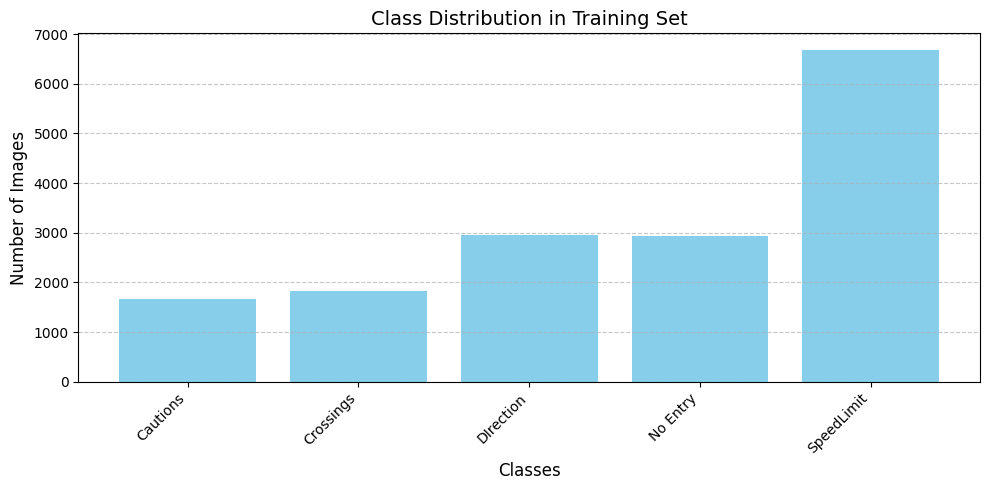

In [10]:
# Extracting classes and their corresponding image counts
classes = list(train_image_counts.keys())
counts = list(train_image_counts.values())

# Create a bar plot to visualize the class distribution
plt.figure(figsize=(10, 5))
plt.bar(classes, counts, color='skyblue')

# Adding titles and labels
plt.title("Class Distribution in Training Set", fontsize=14)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Optional: Enable grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Display the plot
plt.show()

###   **1.1.3 Data splitting, augemntation and preprocessing**

1. **Data Spliting**

* The dataset was split into train and validation set using 80:20 ratio using **tf.keras.utils.image_dataset_from_directory**. This ensured that   80% of the dataset was used for training the model and 20% for validation. The dataset was split into this arrangement to provide enough data to the model for training while holding out a portion to evaluate its performance and generalization ability on unseen data.

---

2. **Data Preprocessing**

 * **Resizing**: All images were resized to a fixed dimension of 128×128 pixels to ensure consistency across the dataset and compatibility with the model input shape.
   
 * **Normalization**: Pixel values were normalized by dividing by 255.0, converting them from the range [0, 255] to [0.0, 1.0]. This accelerates training and improves convergence.

---

   
3. **Data Generator and Augmentations**
   
   * Data loading and augmentation were handled using TensorFlow's image_dataset_from_directory
     
   *  Augmentation techniques were applied using tf.keras.layers:
        
        * RandomRotation(0.8)       
        * RandomZoom(0.3)
        * RandomTranslation(0.2, 0.3)
        * RandomContrast(0.6)



 **Data Augemntation and Downsampling**

In [11]:
# Set target image count, image size, and batch size
target_count = 3000
image_size = (128, 128)
batch_size = 32

# --- AUGMENTATION LAYERS ---
data_augmentation_layers = [
    (layers.RandomRotation(0.8), "Rotation"),
    (layers.RandomZoom(0.3), "Zoom"),
    (layers.RandomTranslation(0.2, 0.3), "Translation"),
    (layers.RandomContrast(0.6), "Contrast")
]

# Function to apply all augmentations to a single image
def augment_image(image):
    """
    Apply a series of augmentations to a single image.
    
    Args:
    - image (tf.Tensor): The input image to be augmented.
    
    Returns:
    - image (tf.Tensor): The augmented image.
    """
    for layer, _ in data_augmentation_layers:
        image = layer(image)
    return image

I0000 00:00:1747029792.270718      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747029792.271401      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [12]:
# Load the dataset, applying a validation split of 20%
train_ds, valid_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir_path,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

# Retrieve class names and create class to index mapping
class_names = train_ds.class_names
class_to_index = {name: idx for idx, name in enumerate(class_names)}


# Normalizing images by dividing by 255.0
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
valid_ds = valid_ds.map(lambda x, y: (x / 255.0, y))


# --- GROUP BY CLASS ---
classwise_data = defaultdict(list)
for images, labels in train_ds:
    for img, lbl in zip(images, labels):
        classwise_data[lbl.numpy()].append(img)

# --- BALANCE DATASET ---
balanced_images = []
balanced_labels = []

for class_name, class_idx in class_to_index.items():
    samples = classwise_data[class_idx]
    count = len(samples)

    if class_name == 'SpeedLimit':
        # Downsample SpeedLimit class to target_count
        selected = random.sample(samples, target_count)
        balanced_images.extend(selected)
        balanced_labels.extend([class_idx] * target_count)
    else:
        # Add original samples
        balanced_images.extend(samples)
        balanced_labels.extend([class_idx] * count)

        # Augment to reach 3k images for other classes
        for _ in range(target_count - count):
            img = random.choice(samples)
            aug_img = augment_image(tf.expand_dims(img, 0))[0]
            balanced_images.append(aug_img)
            balanced_labels.append(class_idx)

# --- FINAL DATASET ---
# Convert the balanced images and labels into a TensorFlow dataset
final_ds = tf.data.Dataset.from_tensor_slices((balanced_images, balanced_labels))
final_ds = final_ds.shuffle(buffer_size=len(balanced_labels)).batch(batch_size)

# --- OPTIONAL: Check distribution ---
print("Final balanced dataset class distribution:")
print(Counter(balanced_labels))

Found 16065 files belonging to 5 classes.
Using 12852 files for training.
Using 3213 files for validation.
Final balanced dataset class distribution:
Counter({0: 3000, 1: 3000, 2: 3000, 3: 3000, 4: 3000})


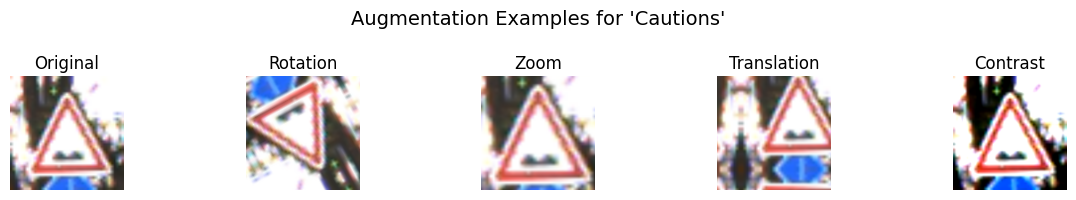

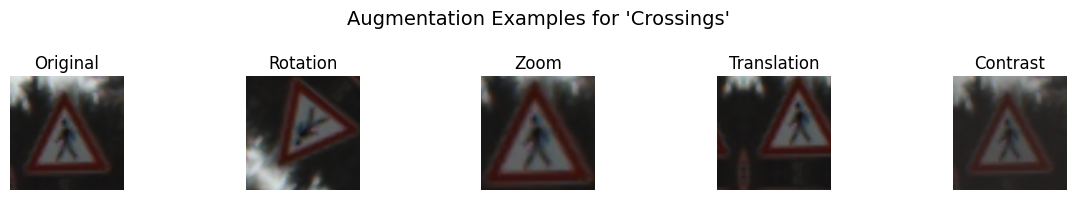

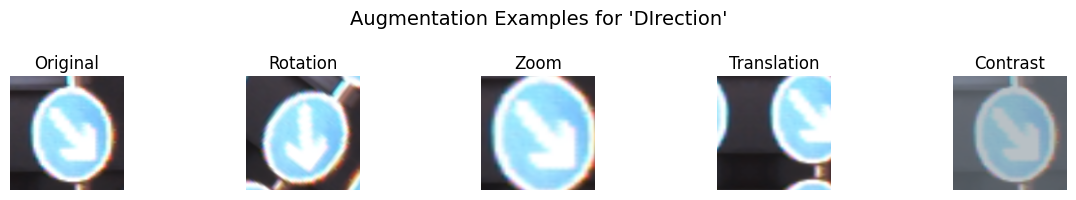

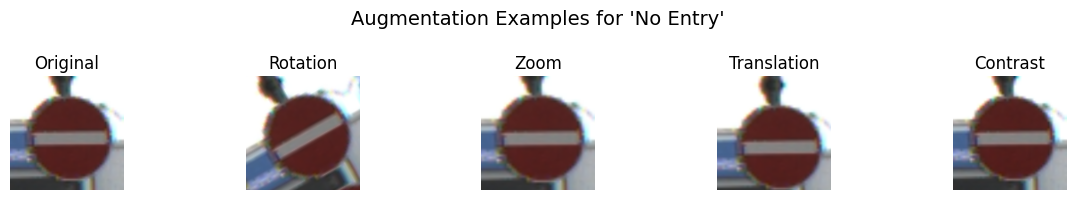

In [13]:
# Visualize augmentations for each class except 'SpeedLimit'
for class_name, class_idx in class_to_index.items():
    if class_name == 'SpeedLimit':
        continue

    original_img = random.choice(classwise_data[class_idx])
    
    plt.figure(figsize=(12, 2))
    
    # Display original image
    plt.subplot(1, 5, 1)
    plt.imshow(original_img)
    plt.title("Original")
    plt.axis("off")
    
    # Apply and display each augmentation
    for i, (layer, name) in enumerate(data_augmentation_layers, start=2):
        aug_img = layer(tf.expand_dims(original_img, 0))[0]
        plt.subplot(1, 5, i)
        plt.imshow(aug_img.numpy())
        plt.title(name)
        plt.axis("off")
    
    plt.suptitle(f"Augmentation Examples for '{class_name}'", fontsize=14)
    plt.tight_layout()
    plt.show()


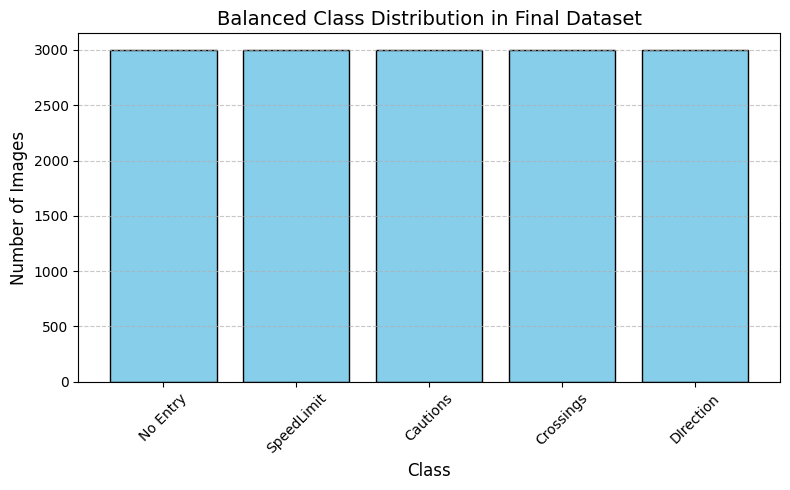

In [14]:
# Extract all labels from the final dataset
all_labels = [int(label.numpy()) for _, label in final_ds.unbatch()]

# Count label occurrences
label_counts = Counter(all_labels)

# Map label indices back to class names
index_to_class = {v: k for k, v in class_to_index.items()}
classes = [index_to_class[i] for i in label_counts]
counts = [label_counts[i] for i in label_counts]

# Plot class distribution
plt.figure(figsize=(8, 5))
plt.bar(classes, counts, color='skyblue', edgecolor='black')
plt.title("Balanced Class Distribution in Final Dataset", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## **1.2. Design, Train, and Evaluate a Baseline Model**

### **Model Architecture and Training Overview**

- **Architecture**:
- 
  The CNN model includes:
  - 3 Convolutional layers (each followed by Max Pooling)
  - 3 Fully Connected (Dense) layers  
  - An Output layer with **Softmax** activation for multi-class classification

---

- **Activation Functions**:

  - **ReLU** is used in convolutional and dense layers to introduce non-linearity  
  - **Softmax** is used in the final layer to output class probabilities




- **Compilation**:

  - **Optimizer**: Adam  
  - **Loss Function**: sparse categorical crossentropy (suitable for integer-labeled multi-class classification)


- **Training Strategy**:


  - Trained for **15 epochs**, chosen based on the trend in training and validation metrics showing consistent improvement without overfitting
    
  - **Early Stopping** was explored but did not improve performance, so a fixed number of epochs was used for better efficiency and stability




### **1.2.1 Model Architecture:**

In [15]:
num_classes = len(class_names) 
base_model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),

    # Convolutional Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Convolutional Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),

    # Output Layer (Softmax for multi-class classification)
    layers.Dense(num_classes, activation='softmax')
])


In [16]:

final_model_path = "/kaggle/working/final_model.keras"
checkpoint_path = "/kaggle/working/best_model.keras"

# Set up the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)


# Compile your model
base_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Start timing
base_start_time = time.time()

# Train the model
base_history = base_model.fit(
    final_ds,
    validation_data=valid_ds,
    callbacks=[checkpoint],
    epochs=15
)

# End timing
base_end_time = time.time()
training_duration = base_end_time - base_start_time
print(f"\nTotal training time: {training_duration:.2f} seconds")

# Save the final model
base_model.save(final_model_path)


Epoch 1/15


I0000 00:00:1747029946.368613      95 service.cc:148] XLA service 0x367db170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747029946.369598      95 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747029946.369623      95 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747029946.702914      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


 12/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.3005 - loss: 1.6444 

I0000 00:00:1747029950.161700      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6236 - loss: 0.8386
Epoch 1: val_accuracy improved from -inf to 0.90756, saving model to /kaggle/working/best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.6238 - loss: 0.8381 - val_accuracy: 0.9076 - val_loss: 0.1983
Epoch 2/15
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8257 - loss: 0.3818
Epoch 2: val_accuracy improved from 0.90756 to 0.97292, saving model to /kaggle/working/best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.8257 - loss: 0.3817 - val_accuracy: 0.9729 - val_loss: 0.0709
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8829 - loss: 0.2525
Epoch 3: val_accuracy improved from 0.97292 to 0.98226, saving model to /kaggle/working/best_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.8829 - loss: 0.2525 - val_accuracy: 0.9823 - val_loss: 0.0449
Epoch 4/15
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9043 - loss: 0.1

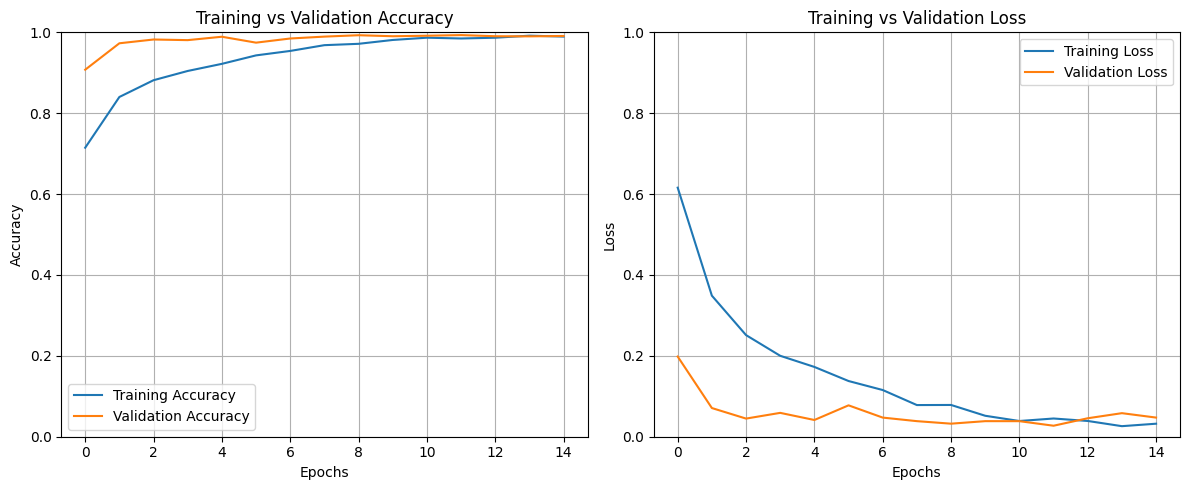

In [17]:


plt.figure(figsize=(12, 5))  # Width, Height in inches

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(base_history.history['accuracy'], label='Training Accuracy')
plt.plot(base_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(base_history.history['loss'], label='Training Loss')
plt.plot(base_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### **Model Evaluation**


The model was evaluated using the validation set. The performance was assessed through the following:

- **Classification Report**:  
  Including precision, recall, and F1-score for each class.
  
- **Confusion Matrix**:  
  Visual representation of correct vs. incorrect predictions for each class.

The model was also used to predict unlabelled test images. The test images were
 - Resized to `128x128` pixels
 - Normalized by scaling pixel values to the [0, 1] range


In [18]:
# Collect all validation images and labels
val_images = []
val_labels = []

for images, labels in valid_ds:
    val_images.append(images)
    val_labels.append(labels)

val_images = np.concatenate(val_images)
val_labels = np.concatenate(val_labels)

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Classification Report:
              precision    recall  f1-score   support

    Cautions       0.97      0.97      0.97       350
   Crossings       0.96      0.98      0.97       386
   DIrection       1.00      1.00      1.00       585
    No Entry       0.99      1.00      1.00       583
  SpeedLimit       1.00      0.99      1.00      1309

    accuracy                           0.99      3213
   macro avg       0.99      0.99      0.99      3213
weighted avg       0.99      0.99      0.99      3213



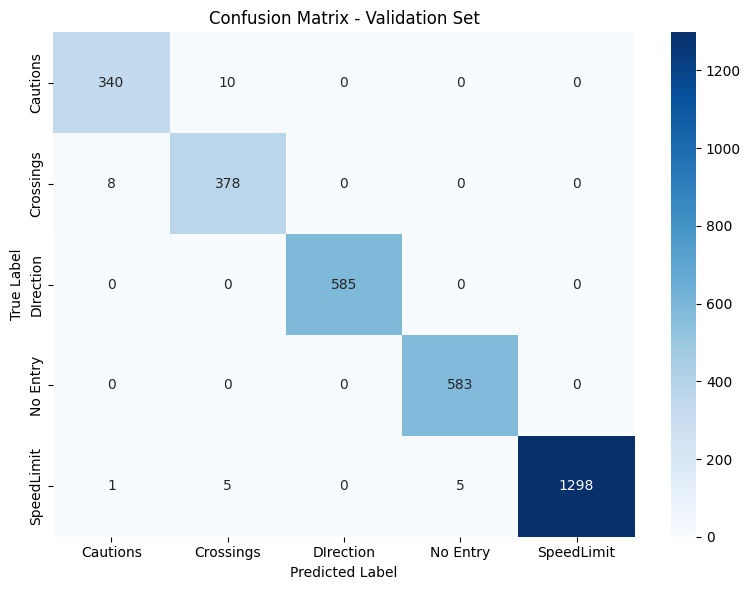

In [19]:
# Make predictions
predictions = base_model.predict(val_images)
predicted_classes = np.argmax(predictions, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(val_labels, predicted_classes, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(val_labels, predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [20]:
# Get test image paths
test_image_paths = [os.path.join(test_dir_path, fname) for fname in os.listdir(test_dir_path)]

# Load and preprocess test images
test_images = []
for path in test_image_paths:
    img = tf.keras.preprocessing.image.load_img(path, target_size=(128, 128))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    test_images.append(img_array)

# Convert to NumPy array
test_images = np.array(test_images)

# Make predictions
predictions_test = base_model.predict(test_images)
predicted_classes_test = np.argmax(predictions_test, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


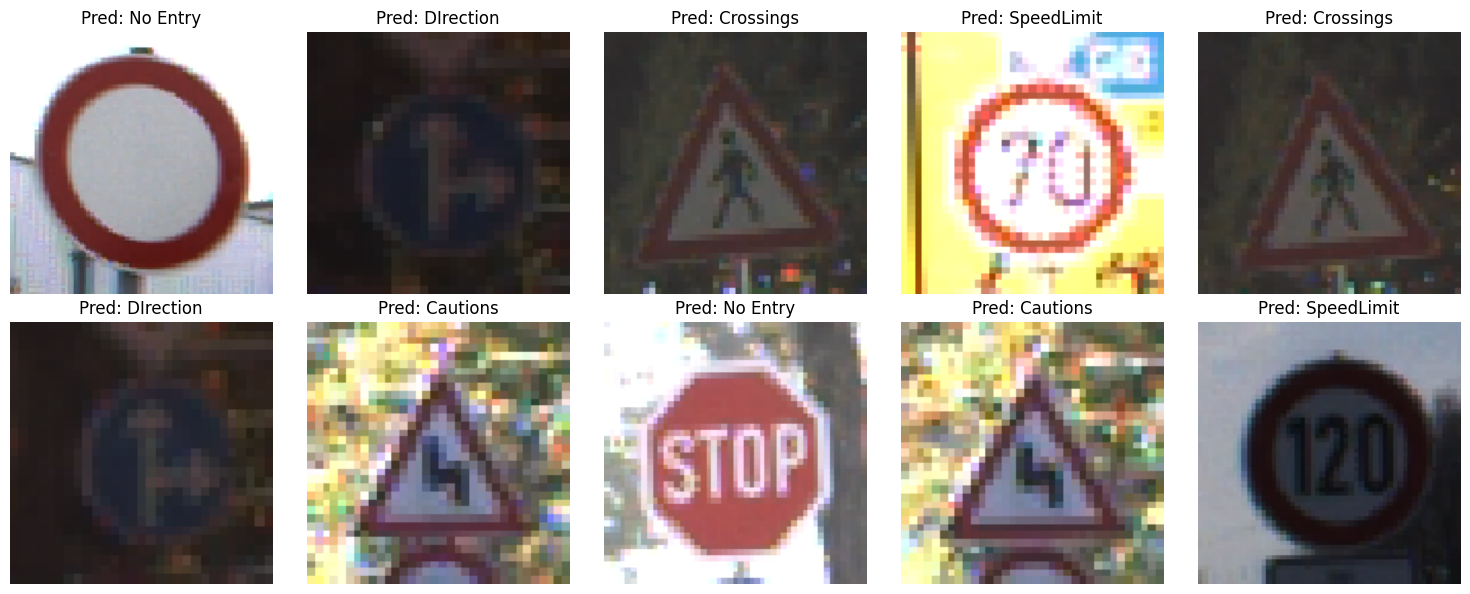

In [21]:
# Plot
plt.figure(figsize=(15, 6))
for i in range(len(test_images)):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Pred: {class_names[predicted_classes_test[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

### **Key Observations**

During the training, the model performance is seen improving steadily. 

- Both the training and validation accuracy improved steadily, indicating proper generalization and no signs of over fitting.
  
- Both the training loss and validation loss improved as the epoch increased.

  
- The accuracy and validation seemed to plateau around 10 epoch, resulting in proper model convergence before the completion of 15 epochs.


Based on the classification report and confusion matrix, the model performed really good with accuracy of 99%.

- Cautions has slightly lower precision compared to other classes, meaning the model sometimes misclassifies other classes as "Cautions."

- SpeedLimit has slightly lower recall, so a few SpeedLimit signs were missed or misclassified.


For the unlabelled test data, the model was able to correctly predict the classes. Overall, the model was able to generalize and predict the classes correctly.


  

##  **1.3. Design, Train , and Evaluate Deeper Architecture with Regularization Layer**

### **Model Architecture and Training Overview**

- **Architecture**:


  The CNN model includes:
  - 4 Convolutional layers (each followed by Batch Normalization and Max Pooling along with Dropout)
  - A GlobalAveragePooling to turn the output into 1D vector
  - 4 Fully Connected (Dense) layers  
  - An Output layer with **Softmax** activation for multi-class classification

---

- **Activation Functions**:

  - **ReLU** is used in convolutional and dense layers to introduce non-linearity
    
  - **Softmax** is used in the final layer to output class probabilities


- **Compilation**:

  - **Optimizer**: Adam (First Deeper model) and SGD (Second Deeper model)
    
  - **Loss Function**: sparse categorical crossentropy (suitable for integer-labeled multi-class classification)


- **Training Strategy**:


  - Trained for 30 epochs, double that of the base model, based on observations of training and validation trends showing continued improvement without overfitting
    
  - **Early Stopping** was explored but did not improve performance, so a fixed number of epochs was used for better efficiency and stability




In [22]:
deeper_model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),

    # Convolutional Layers with L2 Regularization
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', 
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', 
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu', 
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu', 
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu', 
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu', 
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(256, (3, 3), padding='same', activation='relu', 
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.GlobalAveragePooling2D(),  # Using GlobalAveragePooling instead of Flatten

    # Fully Connected Layers
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Output Layer
    layers.Dense(5, activation='softmax')
])

deeper_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,556,261 (5.94 MB)

 Trainable params: 1,550,789 (5.92 MB)

 Non-trainable params: 5,472 (21.38 KB)

###  **1.3.1. Deeper Model with Adam as optimizer**

In [23]:
deeper_final_model_path = "/kaggle/working/final_model_adam.keras"
adam_checkpoint_path = "/kaggle/working/best_model_adam.keras"

# Set up checkpoint callback
adam_checkpoint = ModelCheckpoint(
    filepath=adam_checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

deeper_model.compile(
    optimizer=adam_optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
adam_start_time = time.time()
# Train
history_adam = deeper_model.fit(
    final_ds,
    callbacks=[adam_checkpoint,early_stop],
    validation_data=valid_ds,
    epochs=30
)
# End timing
adam_end_time = time.time()
adam_training_duration = adam_end_time - adam_start_time
print(f"\nTotal training time: {adam_training_duration:.2f} seconds")

# Save the final model
deeper_model.save(deeper_final_model_path)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2665 - loss: 4.1066
Epoch 1: val_accuracy improved from -inf to 0.46343, saving model to /kaggle/working/best_model_adam.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 76s 98ms/step - accuracy: 0.2666 - loss: 4.1061 - val_accuracy: 0.4634 - val_loss: 3.5638
Epoch 2/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4296 - loss: 3.4750
Epoch 2: val_accuracy improved from 0.46343 to 0.47401, saving model to /kaggle/working/best_model_adam.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.4298 - loss: 3.4746 - val_accuracy: 0.4740 - val_loss: 3.2059
Epoch 3/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5165 - loss: 3.1436
Epoch 3: val_accuracy improved from 0.47401 to 0.60878, saving model to /kaggle/working/best_model_adam.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.5165 - loss: 3.1433 - val_accuracy: 0.6088 - val_loss: 2.8095
Epoch 4/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - 

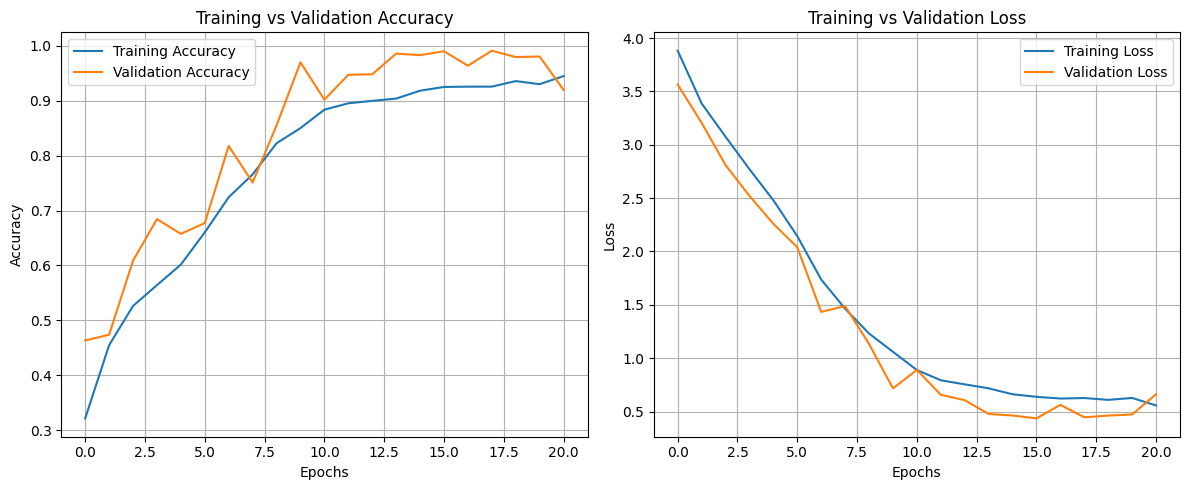

In [24]:
plt.figure(figsize=(12, 5))  # Width, Height in inches

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_adam.history['accuracy'], label='Training Accuracy')
plt.plot(history_adam.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_adam.history['loss'], label='Training Loss')
plt.plot(history_adam.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
Classification Report:
              precision    recall  f1-score   support

    Cautions       0.93      0.99      0.96       350
   Crossings       0.99      0.95      0.97       386
   DIrection       1.00      1.00      1.00       585
    No Entry       1.00      0.99      1.00       583
  SpeedLimit       1.00      0.99      1.00      1309

    accuracy                           0.99      3213
   macro avg       0.98      0.99      0.99      3213
weighted avg       0.99      0.99      0.99      3213



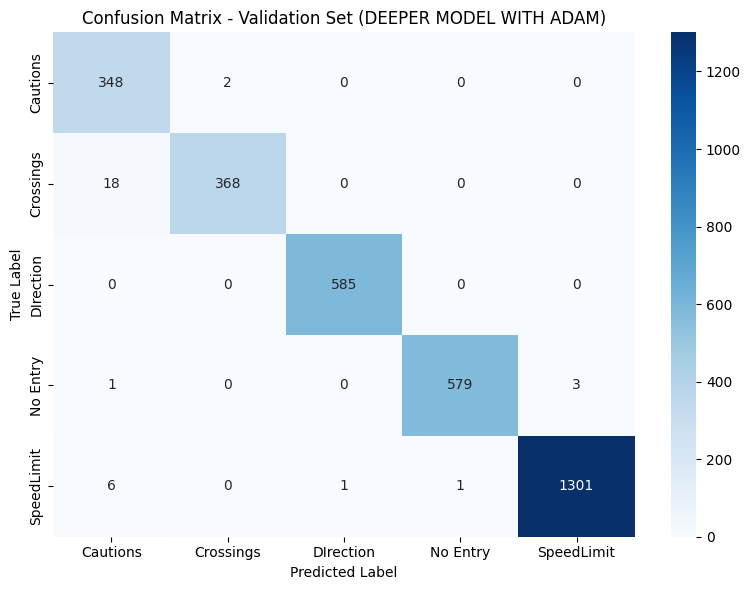

In [25]:
# Make predictions
adam_predictions = deeper_model.predict(val_images)
adam_predicted_classes = np.argmax(adam_predictions, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(val_labels, adam_predicted_classes, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(val_labels, adam_predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix - Validation Set (DEEPER MODEL WITH ADAM)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


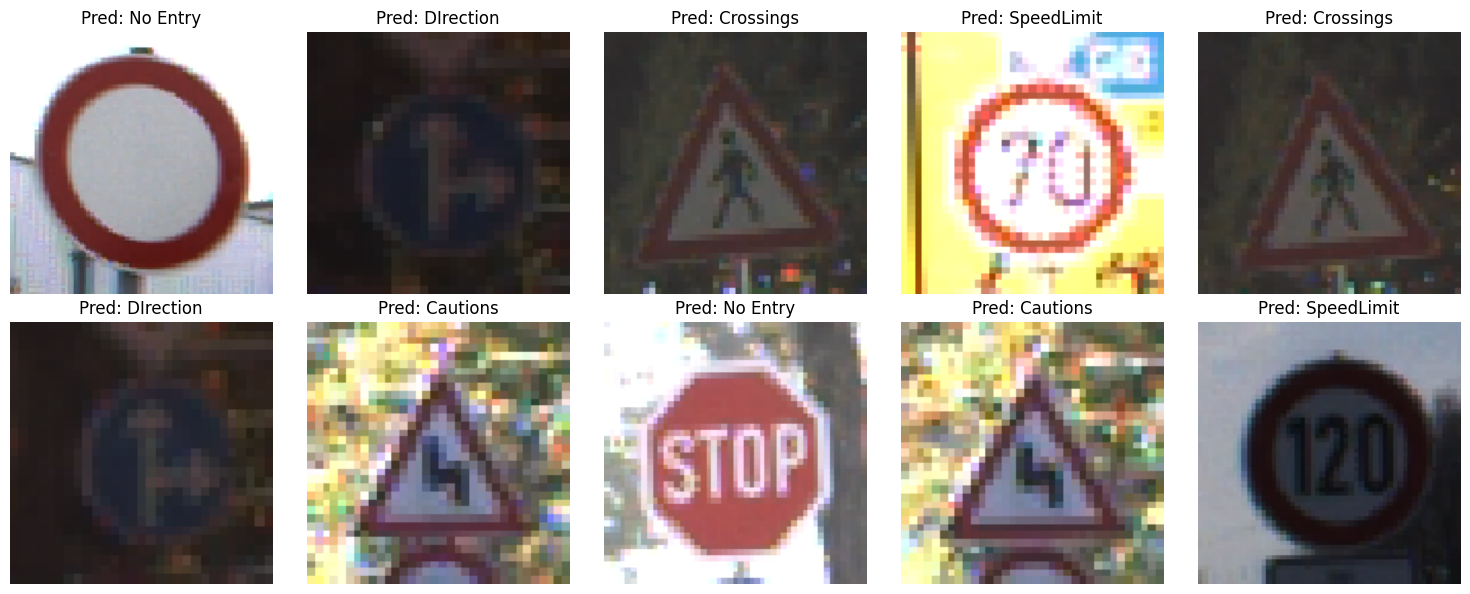

In [26]:
adam_predictions_test = deeper_model.predict(test_images)
adam_predicted_classes_test = np.argmax(adam_predictions_test, axis=1)

# Plot
plt.figure(figsize=(15, 6))
for i in range(len(test_images)):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Pred: {class_names[adam_predicted_classes_test[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


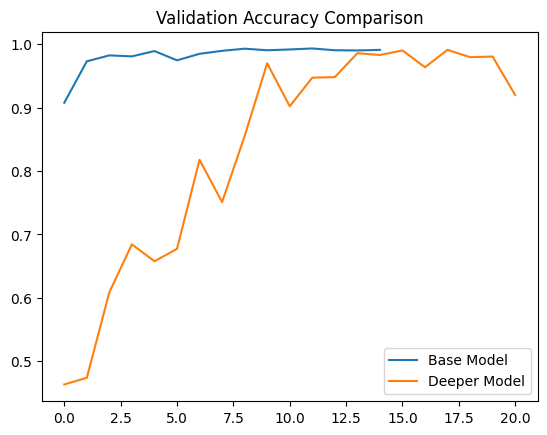

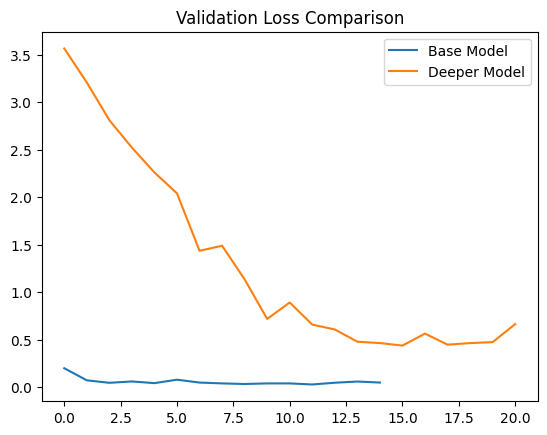

In [27]:
# Accuracy
plt.plot(base_history.history['val_accuracy'], label='Base Model')
plt.plot(history_adam.history['val_accuracy'], label='Deeper Model')
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.show()

# Loss
plt.plot(base_history.history['val_loss'], label='Base Model')
plt.plot(history_adam.history['val_loss'], label='Deeper Model')
plt.title("Validation Loss Comparison")
plt.legend()
plt.show()


In [28]:
print(f"Baseline Training Time: {training_duration:.2f} seconds")
print(f"Adam Training Time:     {adam_training_duration:.2f} seconds")

# Calculate difference and percentage
diff = adam_training_duration - training_duration
percent_diff = (diff / training_duration) * 100


Baseline Training Time: 137.24 seconds
Adam Training Time:     576.32 seconds


**Baseline vs. Deeper Model Performance and Computational Efficiency (ADAM)**

###  **1.3.3.Deeper Model with SGD as optimizer**

In [29]:

deeper_final_model_path_sgd = "/kaggle/working/final_model_sgd.keras"

sgd_checkpoint_path = "/kaggle/working/best_model_sgd.keras"

# Set up the checkpoint callback
checkpoint = ModelCheckpoint(
    filepath=sgd_checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,
    save_weights_only=False,
    mode='max', 
    verbose=1
)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [30]:


sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.004, momentum=0.9)
deeper_model_sgd = clone_model(deeper_model)

deeper_model_sgd.compile(
    optimizer=sgd_optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
sgd_start_time = time.time()
# Train
history_sgd = deeper_model_sgd.fit(
    final_ds,
    validation_data=valid_ds,
    callbacks=[early_stop,checkpoint],
    epochs=30
)
# End timing
sgd_end_time = time.time()
sgd_training_duration = sgd_end_time - sgd_start_time
print(f"\nTotal training time: {sgd_training_duration:.2f} seconds")

# Save the final model
deeper_model_sgd.save(deeper_final_model_path_sgd)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2732 - loss: 4.0897
Epoch 1: val_accuracy improved from -inf to 0.53221, saving model to /kaggle/working/best_model_sgd.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 56s 79ms/step - accuracy: 0.2734 - loss: 4.0892 - val_accuracy: 0.5322 - val_loss: 3.4569
Epoch 2/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4701 - loss: 3.4900
Epoch 2: val_accuracy did not improve from 0.53221
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - accuracy: 0.4701 - loss: 3.4897 - val_accuracy: 0.4494 - val_loss: 3.3995
Epoch 3/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4962 - loss: 3.2531
Epoch 3: val_accuracy improved from 0.53221 to 0.53657, saving model to /kaggle/working/best_model_sgd.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - accuracy: 0.4962 - loss: 3.2529 - val_accuracy: 0.5366 - val_loss: 3.1177
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5137 - loss: 3.0479
Epoch 4: val_accuracy did not

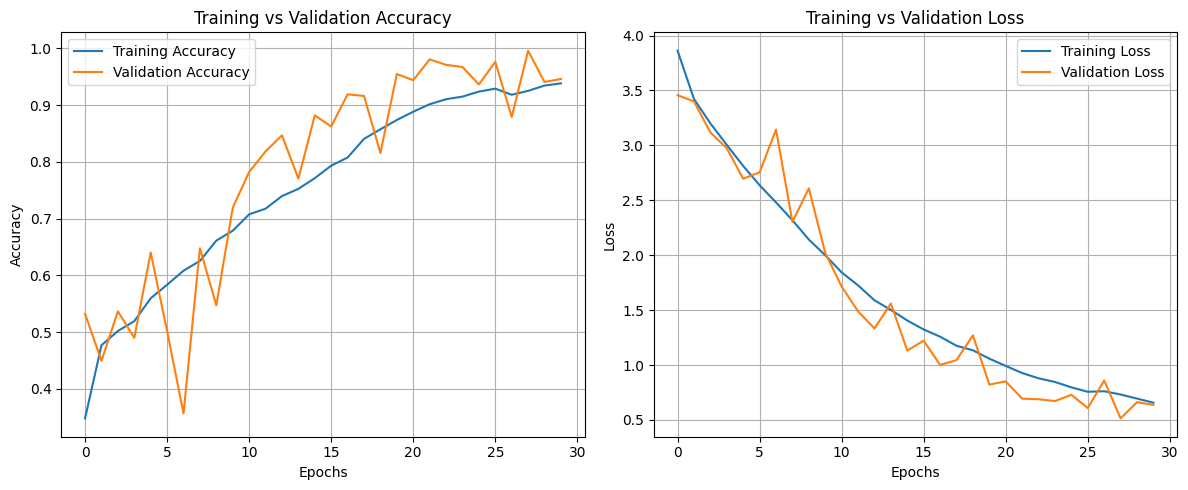

In [31]:
plt.figure(figsize=(12, 5))  # Width, Height in inches

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_sgd.history['accuracy'], label='Training Accuracy')
plt.plot(history_sgd.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_sgd.history['loss'], label='Training Loss')
plt.plot(history_sgd.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
Classification Report:
              precision    recall  f1-score   support

    Cautions       0.99      0.99      0.99       350
   Crossings       0.99      0.99      0.99       386
   DIrection       1.00      1.00      1.00       585
    No Entry       1.00      0.99      1.00       583
  SpeedLimit       1.00      1.00      1.00      1309

    accuracy                           1.00      3213
   macro avg       0.99      0.99      0.99      3213
weighted avg       1.00      1.00      1.00      3213



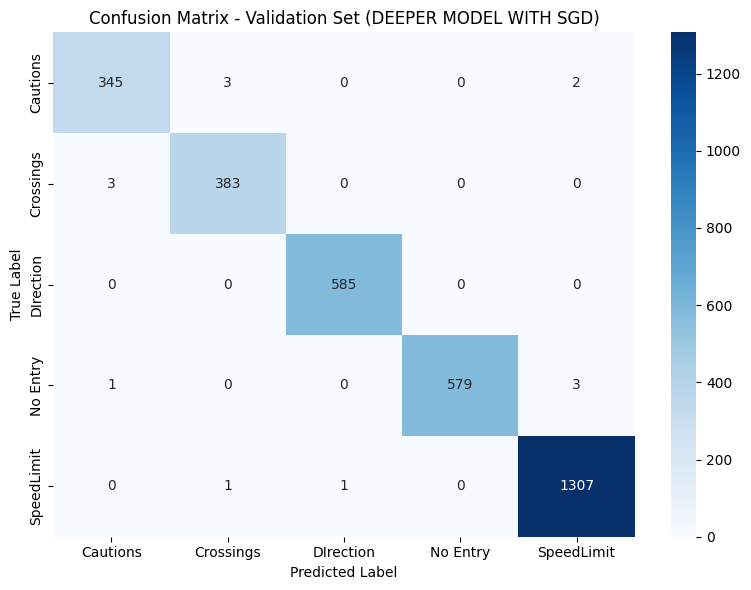

In [32]:
# Make predictions
sgd_predictions = deeper_model_sgd.predict(val_images)
sgd_predicted_classes = np.argmax(sgd_predictions, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(val_labels, sgd_predicted_classes, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(val_labels, sgd_predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix - Validation Set (DEEPER MODEL WITH SGD)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step


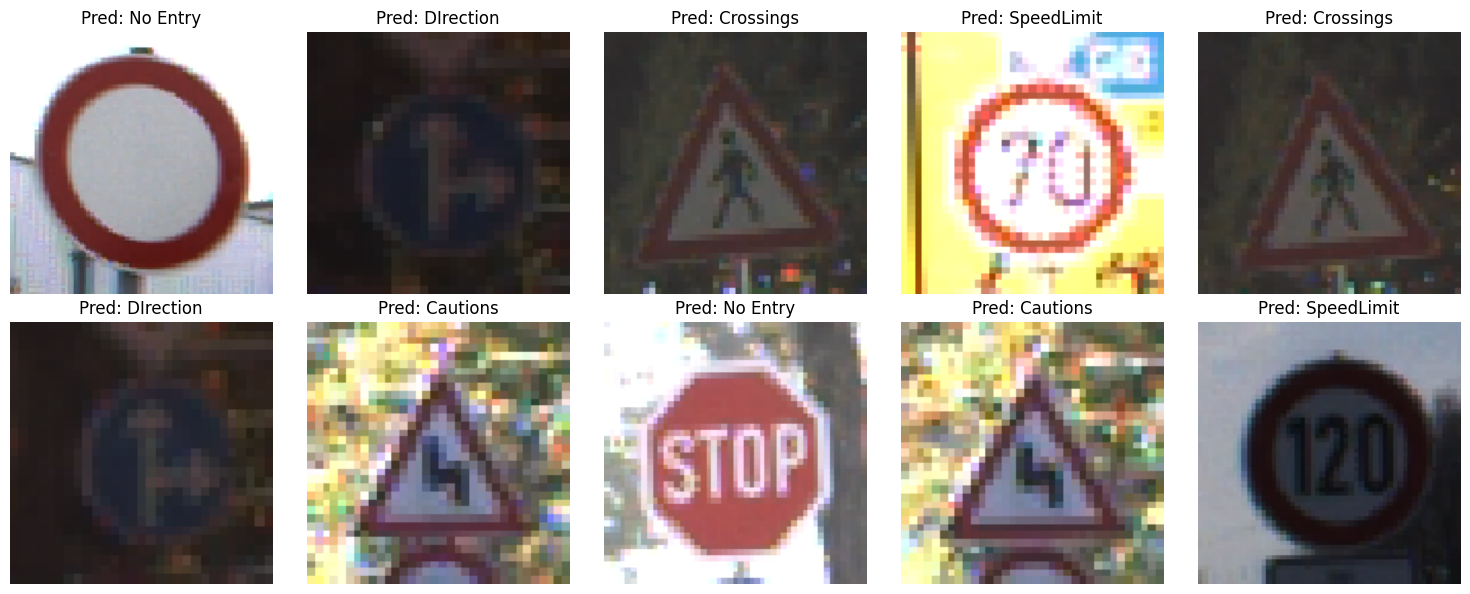

In [33]:
sgd_predictions_test = deeper_model_sgd.predict(test_images)
sgd_predicted_classes_test = np.argmax(sgd_predictions_test, axis=1)

# Plot
plt.figure(figsize=(15, 6))
for i in range(len(test_images)):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Pred: {class_names[sgd_predicted_classes_test[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


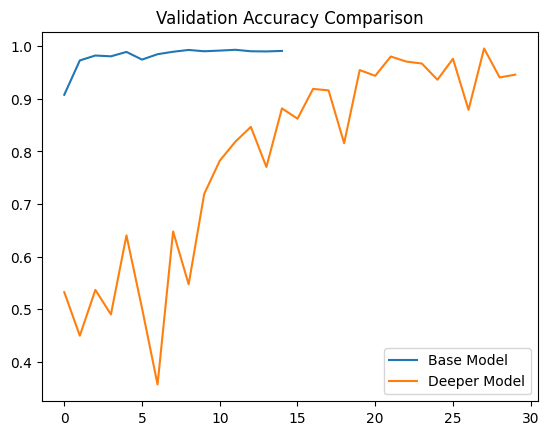

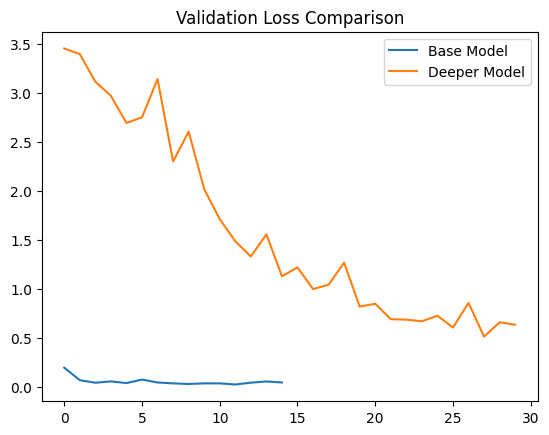

In [34]:
# Accuracy
plt.plot(base_history.history['val_accuracy'], label='Base Model')
plt.plot(history_sgd.history['val_accuracy'], label='Deeper Model')
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.show()

# Loss
plt.plot(base_history.history['val_loss'], label='Base Model')
plt.plot(history_sgd.history['val_loss'], label='Deeper Model')
plt.title("Validation Loss Comparison")
plt.legend()
plt.show()


In [35]:
print(f"Baseline Training Time: {training_duration:.2f} seconds")
print(f"SGD Training Time:     {sgd_training_duration:.2f} seconds")

# Calculate difference and percentage
diff = sgd_training_duration - training_duration
percent_diff = (diff / training_duration) * 100


Baseline Training Time: 137.24 seconds
SGD Training Time:     762.98 seconds


## Model Performance Summary

- Both the **baseline model** and the **deeper models** achieved similar accuracy and classification metrics.
- Deeper architectures did not provide significant improvements over the baseline.

### Baseline Model
- Accuracy: ~99%
- Showed steady improvement in training and validation accuracy.
- Training Time: ~135 seconds
- Loss plateaued around the 10th epoch.
- Overall: Efficient and consistent performance.

### Deeper Model with Adam Optimizer
- Faster learning in early epochs.
- Validation accuracy and loss fluctuated throughout training.
- Training Time: ~576 seconds (21 epochs)
- Slightly lower accuracy than baseline.
- Overall: Unstable despite deeper architecture.

### Deeper Model with SGD Optimizer
- Occasionally higher accuracy, but:
- Training was highly unstable with sharp fluctuations.
- Training Time: ~763 seconds (30 epochs)
- Overall: Most computationally expensive with unstable results.

---

### Conclusion
- All models achieved high accuracy.
- Deeper models introduced more training instability and required longer training times.
- No substantial performance gains were observed over the baseline.
- The baseline model offered:
  - Better generalization
  - Faster convergence
  - Higher efficiency

**Preferred Choice: Baseline Model**


###  **1.3.4. Optimizer Analysis: SGD vs Adam**

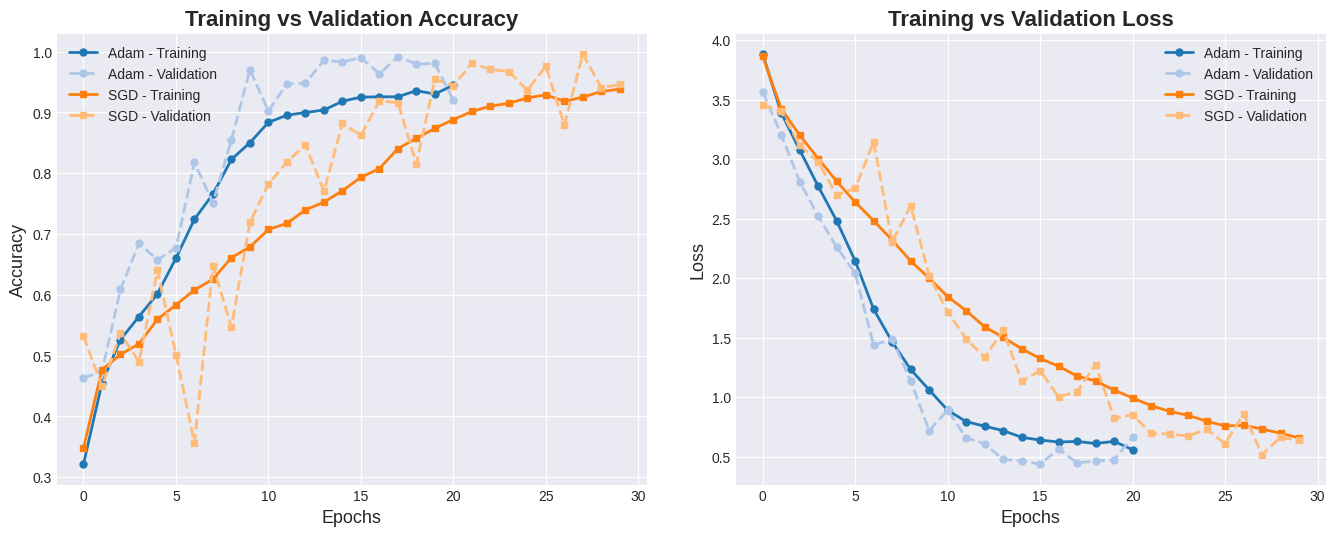

In [36]:
# Use seaborn dark grid style
plt.style.use('seaborn-v0_8-darkgrid')  

# Set figure size
plt.figure(figsize=(14, 6))

# Define custom color palette
colors = {
    'adam_train': '#1f77b4',
    'adam_val':   '#aec7e8',
    'sgd_train':  '#ff7f0e',
    'sgd_val':    '#ffbb78'
}

# ---- Accuracy Plot ----
plt.subplot(1, 2, 1)
plt.plot(history_adam.history['accuracy'], label='Adam - Training', color=colors['adam_train'],
         linewidth=2, marker='o', markersize=5)
plt.plot(history_adam.history['val_accuracy'], label='Adam - Validation', color=colors['adam_val'],
         linewidth=2, linestyle='--', marker='o', markersize=5)
plt.plot(history_sgd.history['accuracy'], label='SGD - Training', color=colors['sgd_train'],
         linewidth=2, marker='s', markersize=5)
plt.plot(history_sgd.history['val_accuracy'], label='SGD - Validation', color=colors['sgd_val'],
         linewidth=2, linestyle='--', marker='s', markersize=5)

plt.title('Training vs Validation Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# ---- Loss Plot ----
plt.subplot(1, 2, 2)
plt.plot(history_adam.history['loss'], label='Adam - Training', color=colors['adam_train'],
         linewidth=2, marker='o', markersize=5)
plt.plot(history_adam.history['val_loss'], label='Adam - Validation', color=colors['adam_val'],
         linewidth=2, linestyle='--', marker='o', markersize=5)
plt.plot(history_sgd.history['loss'], label='SGD - Training', color=colors['sgd_train'],
         linewidth=2, marker='s', markersize=5)
plt.plot(history_sgd.history['val_loss'], label='SGD - Validation', color=colors['sgd_val'],
         linewidth=2, linestyle='--', marker='s', markersize=5)

plt.title('Training vs Validation Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Adjust layout
plt.tight_layout(pad=3.0)
plt.show()

## Comparison Between Adam and SGD

### Adam Optimizer
- Trained for **21 epochs** (early stopping)
- **Training time:** 576.32 seconds
- Showed **stable convergence** with:
  - Gradual increase in accuracy
  - Steady decline in loss
- **Validation accuracy** was more consistent
- Provided **better generalization**
- More efficient for this task due to **faster and smoother learning**

### SGD Optimizer
- Trained for **30 full epochs**
- **Training time:** 762.98 seconds
- Achieved **high training accuracy**
- **Validation accuracy fluctuated heavily** with sharp rises and drops
- Training was **unstable**
- Despite high accuracy, less reliable due to **instability in learning curve**

### Conclusion
- Both optimizers achieved **comparable accuracy**.
- **Adam** outperformed SGD in terms of **stability, generalization, and efficiency**.
- For this task, **Adam is the preferred optimizer**.


### **1.3.5. Challenges and Observations**


- The dataset suffered from **class imbalance**, with the **speed limit class overrepresented** compared to others.
  - This introduced the risk of the model becoming **biased** and not generalizing well to underrepresented classes.
  - Careful consideration was required to **balance the number of samples** across classes.

- **Hyperparameter tuning** was a significant challenge:
  - Finding the right **learning rate** and other hyperparameters required multiple experiments and fine-tuning.
  - Optimal configurations were determined through **trial and error** and iterative testing.

- **Kaggle's limited GPU resources** imposed constraints:
  - The restricted compute capacity limited our ability to perform **longer or more extensive training**.
  - Some deeper experiments had to be reduced or avoided due to **hardware limitations**.


# **2. Fine-Tuning a Pre-Trained Model(Transfer Learning).**

## **2.1 Loading and Adapting a Pre-Trained Model** 

In [37]:
# Load pre-trained MobileNetV2
tbase_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

# Freeze convolutional base for feature extraction
tbase_model.trainable = False

# Custom classification head
x = tbase_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Final model
model_tl = Model(inputs=tbase_model.input, outputs=predictions)
model_tl.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,587,205 (9.87 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## **2.2 Model Training and Fine-Tuning** 

###  **2.2.1 Feature Extraction Training**

In [38]:
# Compile for feature extraction
model_tl.compile(optimizer=Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Measure start time
tl_start_time = time.time()

# Train only custom layers
history_tl = model_tl.fit(final_ds, validation_data=valid_ds, epochs=30)

# Measure end time
tl_end_time = time.time()
tl_training_duration = tl_end_time - tl_start_time

print(f"\nTotal training time: {tl_training_duration:.2f} seconds")

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.7452 - loss: 0.5916 - val_accuracy: 0.9620 - val_loss: 0.1217
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8814 - loss: 0.2682 - val_accuracy: 0.9711 - val_loss: 0.0833
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8938 - loss: 0.2454 - val_accuracy: 0.9701 - val_loss: 0.0771
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9064 - loss: 0.2108 - val_accuracy: 0.9795 - val_loss: 0.0624
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9160 - loss: 0.1923 - val_accuracy: 0.9739 - val_loss: 0.0713
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9176 - loss: 0.1856 - val_accuracy: 0.9732 - val_loss: 0.0752
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9245 - loss: 0.1703 - val_accuracy: 0.9804 - val_loss: 0.0561
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9349 - loss: 0.1547 - val_acc

###  **2.2.2 Fine-Tuning**

In [39]:
# Unfreeze base model
tbase_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

# Re-compile with lower learning rate
model_tl.compile(optimizer=Adam(learning_rate=1e-5),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
# Measure start time
ft_start_time = time.time()

# Train the full model (fine-tuning)
history_ft = model_tl.fit(final_ds, validation_data=valid_ds, epochs=30)

# Measure end time
ft_end_time = time.time()
ft_training_duration = ft_end_time - ft_start_time

print(f"\nTotal fine-tuning time: {ft_training_duration:.2f} seconds")

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 93s 88ms/step - accuracy: 0.6866 - loss: 3.3842 - val_accuracy: 0.9356 - val_loss: 0.2880
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.8643 - loss: 0.8733 - val_accuracy: 0.9045 - val_loss: 0.4587
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.8987 - loss: 0.5222 - val_accuracy: 0.8954 - val_loss: 0.5005
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.9202 - loss: 0.3559 - val_accuracy: 0.9172 - val_loss: 0.5541
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.9343 - loss: 0.2793 - val_accuracy: 0.9434 - val_loss: 0.3603
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.9469 - loss: 0.2155 - val_accuracy: 0.9670 - val_loss: 0.1673
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.9548 - loss: 0.1600 - val_accuracy: 0.9798 - val_loss: 0.0751
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.9569 - loss: 0.1423 - 

## **2.3 Model Evaluation and Prediction** 

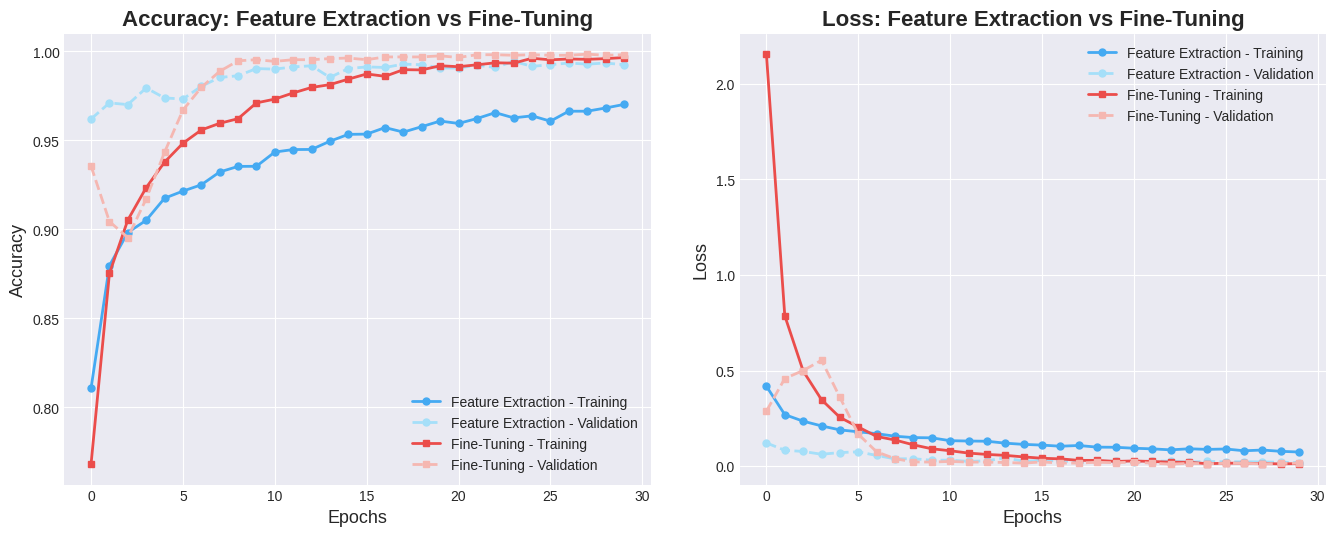

In [40]:
# Use seaborn dark grid style
plt.style.use('seaborn-v0_8-darkgrid')  

# Set figure size
plt.figure(figsize=(14, 6))

# Custom colors for different phases
colors = {
    'tl_train': '#45aaf2',  # Light blue
    'tl_val':   '#a5dff9',  # Lighter blue
    'ft_train': '#eb4d4b',  # Coral red
    'ft_val':   '#f5b7b1'   # Light rose
}
# ---- Accuracy Plot ----
plt.subplot(1, 2, 1)
plt.plot(history_tl.history['accuracy'], label='Feature Extraction - Training', color=colors['tl_train'],
         linewidth=2, marker='o', markersize=5)
plt.plot(history_tl.history['val_accuracy'], label='Feature Extraction - Validation', color=colors['tl_val'],
         linewidth=2, linestyle='--', marker='o', markersize=5)
plt.plot(history_ft.history['accuracy'], label='Fine-Tuning - Training', color=colors['ft_train'],
         linewidth=2, marker='s', markersize=5)
plt.plot(history_ft.history['val_accuracy'], label='Fine-Tuning - Validation', color=colors['ft_val'],
         linewidth=2, linestyle='--', marker='s', markersize=5)

plt.title('Accuracy: Feature Extraction vs Fine-Tuning', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# ---- Loss Plot ----
plt.subplot(1, 2, 2)
plt.plot(history_tl.history['loss'], label='Feature Extraction - Training', color=colors['tl_train'],
         linewidth=2, marker='o', markersize=5)
plt.plot(history_tl.history['val_loss'], label='Feature Extraction - Validation', color=colors['tl_val'],
         linewidth=2, linestyle='--', marker='o', markersize=5)
plt.plot(history_ft.history['loss'], label='Fine-Tuning - Training', color=colors['ft_train'],
         linewidth=2, marker='s', markersize=5)
plt.plot(history_ft.history['val_loss'], label='Fine-Tuning - Validation', color=colors['ft_val'],
         linewidth=2, linestyle='--', marker='s', markersize=5)

plt.title('Loss: Feature Extraction vs Fine-Tuning', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Final layout
plt.tight_layout(pad=3.0)
plt.show()


In [41]:
# Evaluate final fine-tuned model
test_loss, test_accuracy = model_tl.evaluate(valid_ds)
print(f"Validation Loss: {test_loss:.4f}")
print(f"Validation Accuracy: {test_accuracy:.4f}")

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9987 - loss: 0.0129
Validation Loss: 0.0158
Validation Accuracy: 0.9981


101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step
Classification Report:
              precision    recall  f1-score   support

    Cautions       0.99      1.00      0.99       350
   Crossings       1.00      0.99      1.00       386
   DIrection       1.00      1.00      1.00       585
    No Entry       1.00      1.00      1.00       583
  SpeedLimit       1.00      1.00      1.00      1309

    accuracy                           1.00      3213
   macro avg       1.00      1.00      1.00      3213
weighted avg       1.00      1.00      1.00      3213



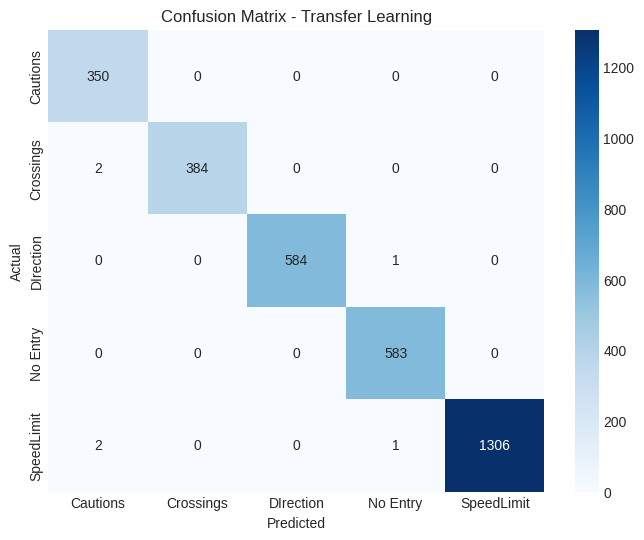

In [42]:
# Predictions
pred_probs = model_tl.predict(valid_ds)
pred_labels = np.argmax(pred_probs, axis=1)

# Report & Confusion Matrix
print("Classification Report:")
print(classification_report(val_labels, pred_labels, target_names=class_names))

cm = confusion_matrix(val_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Transfer Learning")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


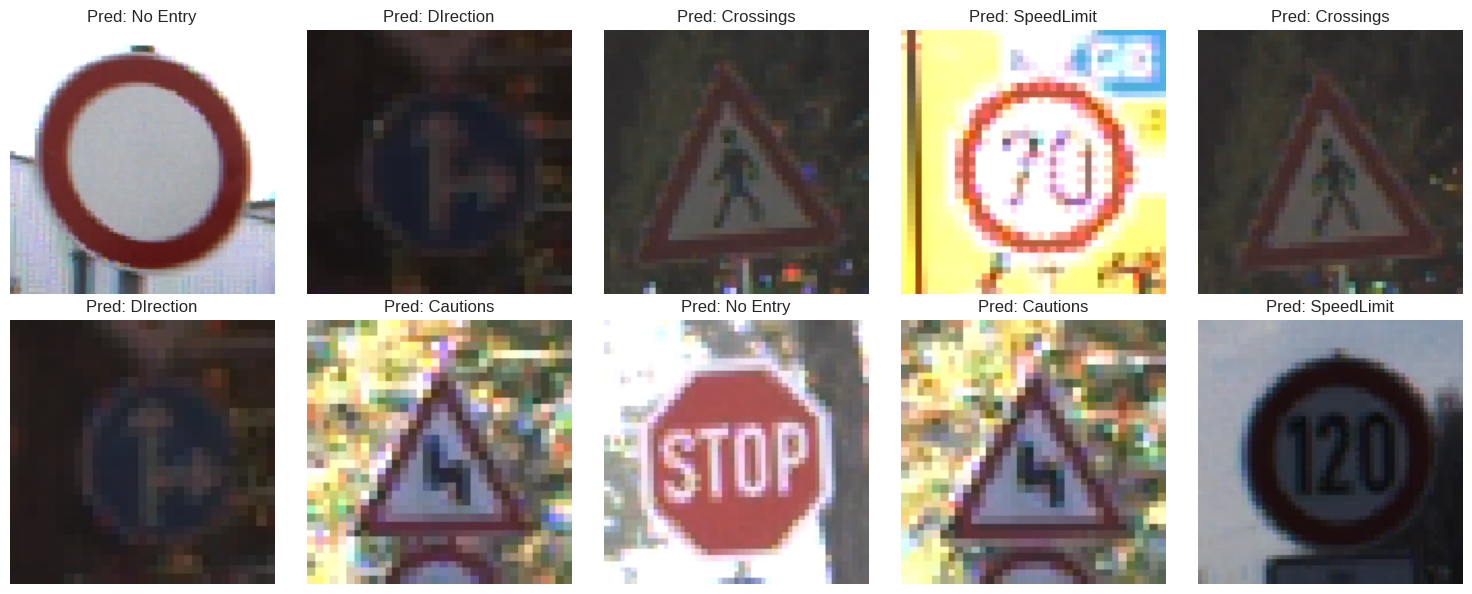

In [43]:
# Predict
predictions = model_tl.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Plot predictions
plt.figure(figsize=(15, 6))
for i in range(len(test_images)):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Pred: {class_names[predicted_classes[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Fine Tuning and Transfer Learning

The project utilized **MobileNetV2** for transfer learning due to its balance of performance and efficiency. Both **feature extraction** and **fine-tuning** approaches were explored.

### Feature Extraction
- All **convolutional layers were frozen**, and only custom top layers were trained.
- The following custom layers were added:
  - `GlobalAveragePooling` layer  
  - `Dense` layer with 256 units  
  - `Dropout` layer  
  - Output layer with `Softmax` activation
- Showed **steady improvement** in both training and validation accuracy.
- **Validation loss** was stable.
- **Training time:** ~209.95 seconds

### Fine Tuning
- The **last 30 layers** of MobileNetV2 were **unfrozen**.
- Trained with a **lower learning rate** to avoid disrupting pre-trained weights.
- Resulted in **significant improvement** in validation accuracy and loss.
- Achieved **near-perfect accuracy**, with **loss close to zero**.
- Showed **minimal fluctuations**, indicating stable and efficient learning.
- **Training time:** ~670.47 seconds

### Summary and Comparison
- Transfer learning provided:
  - **Faster convergence**
  - **Steady performance**
  - **Better accuracy** compared to models trained from scratch
- Although it required **more computational power and time**, the **performance gains were significant**.
